# Projeto 1: Regressões pra prever preço das ações.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

### Pegando e organizando os dados 

In [10]:
cotacoes = pd.read_parquet(r'C:\Users\lsiqu\dev\base_dados_br\cotacoes.parquet')

acao_escolhida = 'MGLU3'

dados = cotacoes[cotacoes['ticker'] == acao_escolhida]

In [11]:
datas = pd.to_datetime(dados['data'].iloc[:-1]).dt.date
dados = dados[['preco_fechamento_ajustado', 'volume_negociado']]

### Criando nosso Y.
Iremos usar o preço da ação e o volume de um dia pra prever a cotação do dia seguinte.

In [12]:
dados['cotacao_dia_seguinte'] = dados['preco_fechamento_ajustado'].shift(-1)
dados = dados.dropna()

In [13]:
tamanho_dados_treinamento = int(len(dados) * 0.8)

In [14]:
#vamos escalar os dados entre 0 e 1. 
#Mas tem que escalar os dados de teste e treino individualmente! 
escalador_treinamento = MinMaxScaler(feature_range=(0, 1))
escalador_teste = MinMaxScaler(feature_range=(0, 1))

dados_entre_0_e_1_treinamento = escalador_treinamento.fit_transform(dados.iloc[0: tamanho_dados_treinamento, :])

dados_entre_0_e_1_teste = escalador_teste.fit_transform(dados.iloc[tamanho_dados_treinamento: , :])

In [15]:
x_treinamento = dados_entre_0_e_1_treinamento[:,:2]
y_treinamento = dados_entre_0_e_1_treinamento[:,2:]

x_teste = dados_entre_0_e_1_teste[:,:2]
y_teste = dados_entre_0_e_1_teste[:,2:]

### Criando o modelo de regressão normal.

In [16]:
regressao_linear = LinearRegression()
regressao_linear.fit(x_treinamento, y_treinamento)

LinearRegression()

In [17]:
precos_preditos = regressao_linear.predict(x_teste)

In [18]:
score_treinamento = regressao_linear.score(x_treinamento, y_treinamento)

In [19]:
score_teste = regressao_linear.score(x_teste, y_teste)

In [20]:
dados_teste = np.concatenate((x_teste, y_teste),axis=1)
dados_preditos = np.concatenate((x_teste, precos_preditos),axis=1)

In [21]:
#tirando escalas dos dados

precos_teste_reais = escalador_teste.inverse_transform(dados_teste)
precos_teste_preditos = escalador_teste.inverse_transform(dados_preditos)

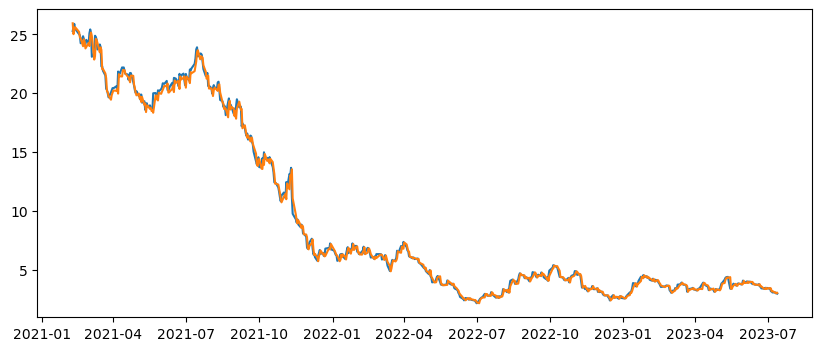

In [22]:
fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_reais[:, 2])
ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_preditos[:, 2])

In [23]:
#precos_teste_preditos[:, 2] 

In [24]:
#precos_teste_reais[:, 2]

In [25]:
#np.around((precos_teste_reais[:, 2] - precos_teste_preditos[:, 2]), 2)

# Avaliação

In [26]:
from datetime import date

In [27]:
df = pd.DataFrame(precos_teste_preditos, index = datas.iloc[tamanho_dados_treinamento:])

df.columns = ['preco', 'volume', 'preco_predito_dia_seguinte']

df['retorno'] = df['preco'].pct_change()

df['comprado_vendido'] = pd.NA

df.loc[df['preco_predito_dia_seguinte'] > df['preco'], 'comprado_vendido'] = 'comprado'
df.loc[df['preco_predito_dia_seguinte'] < df['preco'], 'comprado_vendido'] = 'vendido'

df['acertos'] = pd.NA

df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] > 0), 'acertos'] = 1
df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] < 0), 'acertos'] = 0
df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] > 0), 'acertos'] = 0
df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] < 0), 'acertos'] = 1
df.loc[df['acertos'].isna(), 'acertos'] = 0

df = df.dropna()

In [28]:
acertou_o_lado = df['acertos'].sum()/len(df)
errou_o_lado = 1 - acertou_o_lado

In [29]:
df['retorno_absoluto'] = df['retorno'].abs()

In [30]:
media_lucros_e_perdas = df.groupby('acertos')['retorno_absoluto'].mean()

media_lucros_e_perdas

acertos
0    0.034567
1    0.033934
Name: retorno_absoluto, dtype: float64

In [31]:
exp_mat_lucro = acertou_o_lado * media_lucros_e_perdas[1] - media_lucros_e_perdas[0] * errou_o_lado

exp_mat_lucro * 100

0.1951556744513267

,retorno_acum_modelo,retorno_acum_acao
data,,
2021-02-10,0.03585,-0.035850
2021-02-11,0.021509,-0.022502
2021-02-12,0.011147,-0.012586
2021-02-17,0.027159,-0.028223
2021-02-18,0.045703,-0.045767
...,...,...
2023-07-07,0.650966,-0.878719
2023-07-10,0.718459,-0.883677
2023-07-11,0.712824,-0.883295


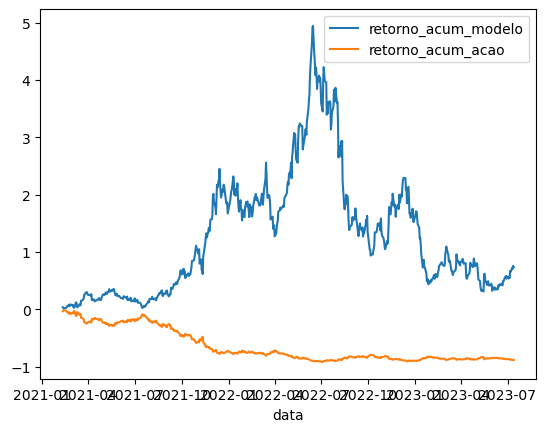

In [32]:
df['retorno_modelo'] = pd.NA

df.loc[df['acertos'] == True, 'retorno_modelo'] = df.loc[df['acertos'] == True]['retorno_absoluto']
df.loc[df['acertos'] == False, 'retorno_modelo'] = df.loc[df['acertos'] == False]['retorno_absoluto'] * - 1

df['retorno_acum_modelo'] = (1 + df['retorno_modelo']).cumprod() - 1
df['retorno_acum_acao'] = (1 + df['retorno']).cumprod() - 1

retornos = df[['retorno_acum_modelo', 'retorno_acum_acao']]

retornos.plot() 
display(retornos)
#PETR4: Se a expectativa matemática é negativa, cedo ou tarde vc vai quebrar. 
#CEAB3: Olha como o modelo precisa de muitos dados pra conseguir ajustar. Com CEAB que é nova deu muito ruim.
#Nesses modelos muito apertados tem que tomar muito cuidado com custo. Comrpou no fechamento? E corretagem?
#Dados intraday pra pegar entradas e saidas exatas.

In [33]:
# regressao_ridge = Ridge(alpha = 3) #mudar o alpha
# regressao_ridge.fit(x_treinamento, y_treinamento)

In [34]:
# precos_preditos = regressao_ridge.predict(x_teste)
# score_treinamento = regressao_ridge.score(x_treinamento, y_treinamento)
# score_teste = regressao_ridge.score(x_teste, y_teste)
# dados_teste = np.concatenate((x_teste, y_teste),axis=1)
# dados_preditos = np.concatenate((x_teste, precos_preditos),axis=1)
# precos_teste_reais = escalador_teste.inverse_transform(dados_teste)
# precos_teste_preditos = escalador_teste.inverse_transform(dados_preditos)

display(score_treinamento)
display(score_teste)

0.9988429369709462

0.9973296054654582

In [35]:
# fig, ax = plt.subplots(figsize = (10, 4))

# ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_reais[:, 2])
# ax.plot(datas.iloc[tamanho_dados_treinamento:], precos_teste_preditos[:, 2])

In [36]:
# df = pd.DataFrame(precos_teste_preditos, index = datas.iloc[tamanho_dados_treinamento:])

# df.columns = ['preco', 'volume', 'preco_predito_dia_seguinte']

# df['retorno'] = df['preco'].pct_change()

# df['comprado_vendido'] = pd.NA

# df.loc[df['preco_predito_dia_seguinte'] > df['preco'], 'comprado_vendido'] = 'comprado'
# df.loc[df['preco_predito_dia_seguinte'] < df['preco'], 'comprado_vendido'] = 'vendido'

# df['acertos'] = pd.NA

# df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] > 0), 'acertos'] = 1
# df.loc[(df['comprado_vendido'] == 'comprado') & (df['retorno'] < 0), 'acertos'] = 0
# df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] > 0), 'acertos'] = 0
# df.loc[(df['comprado_vendido'] == 'vendido') & (df['retorno'] < 0), 'acertos'] = 1
# df.loc[df['acertos'].isna(), 'acertos'] = 0

# df = df.dropna()

# acertou_o_lado = df['acertos'].sum()/len(df)
# errou_o_lado = 1 - acertou_o_lado

# df['retorno_absoluto'] = df['retorno'].abs()

# media_lucros_e_perdas = df.groupby('acertos')['retorno_absoluto'].mean()

# exp_mat_lucro = acertou_o_lado * media_lucros_e_perdas[1] - media_lucros_e_perdas[0] * errou_o_lado

# exp_mat_lucro * 100

In [37]:
# df['retorno_modelo'] = pd.NA

# df.loc[df['acertos'] == True, 'retorno_modelo'] = df.loc[df['acertos'] == True]['retorno_absoluto']
# df.loc[df['acertos'] == False, 'retorno_modelo'] = df.loc[df['acertos'] == False]['retorno_absoluto'] * - 1

# df['retorno_acum_modelo'] = (1 + df['retorno_modelo']).cumprod() - 1
# df['retorno_acum_acao'] = (1 + df['retorno']).cumprod() - 1

# retornos = df[['retorno_acum_modelo', 'retorno_acum_acao']]

# retornos.plot() 
# display(retornos)